In [8]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [9]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [10]:
pd.options.display.float_format = '{:,.2f}'.format

### 0.2 : Connection to Snowflake

In [11]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [16]:
genre_medal = run_query('''
WITH TEMP AS (
select max_prod.content_analytics.asset_medals.TITLE_ID, TITLE, OFFERING_START_DATE, OFFERING_END_DATE, PROGRAMMING_PROVIDED_GENRE, HOME_TERRITORY_OBSERVED_MEDAL, PILLAR_GENRES
from max_prod.content_analytics.asset_medals
inner join max_prod.catalog.vw_title_genres 
on max_prod.content_analytics.asset_medals.TITLE_ID=max_prod.catalog.vw_title_genres.TITLE_ID
where PROGRAMMING_PROVIDED_GENRE = 'Pay1' or PROGRAMMING_PROVIDED_GENRE = 'Popcorn'
)

, first_window AS(
SELECT title_id, MIN(offering_start_date) AS first_offer_window
FROM TEMP
GROUP BY 1
)

SELECT TEMP.*
FROM TEMP
JOIN first_window fw
ON temp.title_id = fw.title_id
and temp.offering_start_date = fw.first_offer_window
''')

In [17]:
genre_medal[genre_medal['title'] == 'Wonder Woman 1984']

,title_id,title,offering_start_date,offering_end_date,programming_provided_genre,home_territory_observed_medal,pillar_genres
85,GX9KHPw1OIMPCJgEAAAAD,Wonder Woman 1984,2020-12-25,2021-01-25,Popcorn,Platinum,Action/Adventure


In [18]:
launch_date = run_query('''
--*************************************************** USE THIS
-- building new table off of TAD
with tentpole_ids as (
select stg.asset_title_long
  , offering_start_date as offering_start_date --limiting returning ID,
  , stg.viewable_id
  , rank() over (partition by stg.asset_title_long order by offering_start_date) as rank
from max_prod.catalog.tentpole_asset_offering_dim tad
inner join max_prod.staging.tentpole_titles_stg stg
  on stg.viewable_id=tad.viewable_id
  and stg.territory = tad.territory
where stg.territory = 'HBO MAX DOMESTIC'
  
group by 1,2,3
)
select   
    tid.asset_title_long
    , tid.viewable_id as title_id
    , map.imdb_id as imdb_id
    , stg.theatrical_release_date
    ,to_date(coalesce(pop.theatrical_release_date, tid.offering_start_date)) as offering_start_date --applying popcorn release dates overridding Pay-1 offering dates for popcorn titles
    ,(case when pop.theatrical_release_date is not null
        then datediff(day,pop.theatrical_release_date,stg.theatrical_release_date) --calculate window with new applied date (should be 0 for popcorn)
      else days_from_theatrical end) as days_from_theatrical1
    ,datediff(days,stg.theatrical_release_date,'2020-05-20') as days_from_max_launch --recalculating windows from titles that premiered before MAX launch
    ,(case when days_from_theatrical1 = 0 then 0
     when days_from_max_launch<=0 then days_from_theatrical1
     else days_from_max_launch end) as days_from_theatrical2
    ,days_on_hbo_max
    ,cumulative_viewing_subs
    ,cumulative_first_views
    ,cumulative_viewing_subs/denom.viewing_subs as pct_actives
    ,area_gross
    ,bdg.AMOUNT as budget
from tentpole_ids tid
inner join max_prod.staging.tentpole_titles_stg stg
    on tid.viewable_id=stg.viewable_id
    and stg.territory = 'HBO MAX DOMESTIC'
    and stg.theatrical_release_date is not null
left join max_prod.catalog.popcorn_titles pop 
    on pop.viewable_id=stg.viewable_id
left join max_prod.ckg.ed_wm_wb_imdb_mapping map --vid to imdb_id
    on map.viewable_id=stg.viewable_id
    and studio = 'HBO'
left join "MAX_PROD"."CKG".imdb_boxoffice_opening_weekends bo --title_id to imdb_id
    on bo.title_id=map.imdb_id
    and (area_code='XDOM' or area_code is null)
left join "MAX_PROD"."CKG".IMDB_BOXOFFICE_TITLE_BUDGET bdg -- budget title_id to imdb_id
    on bdg.title_id=map.imdb_id
left join max_prod.content_analytics.new_title_release_days_on_platform dop 
    on tid.viewable_id = dop.title_id
JOIN "MAX_PROD"."CONTENT_ANALYTICS"."CUMULATIVE_SUBS_DENOM"  denom 
    on to_varchar(dop.FIRST_RELEASE_DATE, 'yyyy-mm-dd') = denom.start_date
    and dop.days_on_hbo_max = denom.days_since_release+1
where 1=1
    --and area_gross is not null
    and rank = 1
    and title_level = 'Series and Movies'
    and stg.is_pay_1 =1
    and days_on_hbo_max = 90
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14
order by 2 desc
''')

In [60]:
launch_date.area_gross.max()

134008624.0

In [19]:
launch_date.tail(3)

,asset_title_long,title_id,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical1,days_from_max_launch,days_from_theatrical2,days_on_hbo_max,cumulative_viewing_subs,cumulative_first_views,pct_actives,area_gross,budget
168,The Call of the Wild,GX1ozeARCl6vDcwEAAAF9,tt7504726,2019-12-25,2020-11-29,312,147,147,90,920407,26197,0.047031,"24,791,624.00","135,000,000.00"
169,Underwater,GX1oymw295cLCTQEAAAFt,tt5774060,2020-01-10,2020-11-22,296,131,131,90,1371037,34513,0.070896,"7,008,297.00","80,000,000.00"
170,Dolittle,GX1oycwoNEsMslAEAAAAI,tt6673612,2020-01-17,2020-11-15,289,124,124,90,1501877,37595,0.079144,"21,844,045.00","175,000,000.00"


In [20]:
launch_date[['asset_title_long', 'imdb_id', 'area_gross', 'budget']].isnull().sum()/len(launch_date)

asset_title_long   0.00
imdb_id            0.00
area_gross         0.12
budget             0.32
dtype: float64

In [21]:
genre_medal.head()

,title_id,title,offering_start_date,offering_end_date,programming_provided_genre,home_territory_observed_medal,pillar_genres
0,GYPXEhQg3DFbCwwEAAADm,News of the World,2021-09-05,2022-12-01,Pay1,Silver,Action/Adventure
1,GXpTQtgV6ax-auwEAABc3,The Good Liar,2020-06-14,2021-03-01,Pay1,Bronze,Drama
2,GYXB0OgEQO5OhegEAAAAl,King Richard,2021-11-19,2021-12-20,Popcorn,Platinum,Drama
3,GYK0lqgy8KZiWvwEAAAAH,Shiva Baby,2021-07-08,2024-07-01,Pay1,Bronze,Comedy
4,GYbzvWABDj8LDwgEAAAAp,The Last Duel,2022-01-14,2022-09-01,Pay1,Gold,Drama


In [22]:
movie_hbo = pd.merge(genre_medal[['title_id', 'title', 'home_territory_observed_medal', 'pillar_genres']],
                    launch_date[['title_id','imdb_id', 'theatrical_release_date', 'offering_start_date', 'days_from_theatrical2', 'pct_actives',
                                 'days_from_max_launch', 'cumulative_viewing_subs', 'cumulative_first_views', 'area_gross', 'budget']],
                    on = 'title_id', how = 'inner')

In [23]:
# Catigorical feature 
category_onehot = pd.get_dummies(movie_hbo['pillar_genres'], prefix='genre')
movie_hbo=pd.concat([movie_hbo, category_onehot], axis = 1)

In [24]:
medal_onehot = pd.get_dummies(movie_hbo['home_territory_observed_medal'], prefix='medal')
movie_hbo=pd.concat([movie_hbo, medal_onehot], axis = 1)

In [25]:
# Medal Data
medal_dict = {'Silver':2, 'Bronze':3, 'Gold':1 , 'Platinum':0}
movie_hbo['medal_number'] = movie_hbo['home_territory_observed_medal'].replace(medal_dict)

In [26]:
movie_hbo['log_cumulative_first_views'] = np.log2(movie_hbo['cumulative_first_views'])

In [27]:
movie_hbo.title_id.count()

103

# Correlation

In [28]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [29]:
data = movie_hbo.copy()

In [30]:
data['pct_actives'] = data['pct_actives'].astype(float)

In [32]:
data.head()

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views
0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,0,0,0,1,2,14.63
1,GXpTQtgV6ax-auwEAABc3,The Good Liar,Bronze,Drama,tt5563334,2019-11-15,2020-06-14,187,0.02,187,186115,10519,"5,605,051.00","10,000,000.00",0,0,1,0,0,0,0,0,1,0,0,0,3,13.36
2,GYXB0OgEQO5OhegEAAAAl,King Richard,Platinum,Drama,tt9620288,2021-11-19,2021-11-19,0,0.24,-548,7612114,236213,"5,406,033.00","50,000,000.00",0,0,1,0,0,0,0,0,0,0,1,0,0,17.85
3,GYK0lqgy8KZiWvwEAAAAH,Shiva Baby,Bronze,Comedy,tt11317142,2020-03-15,2021-07-08,66,0.01,66,307494,1415,"7,160.00",nan,0,1,0,0,0,0,0,0,1,0,0,0,3,10.47
4,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,0,1,0,0,1,15.02


In [33]:
FEATURE_COLS = ['days_from_theatrical2', 'area_gross', 'budget', 'genre_Action/Adventure ', 'genre_Comedy', 'genre_Drama', 'genre_Horror ', 
                'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 'medal_number', 'medal_Bronze', 
                'medal_Gold', 'medal_Platinum', 'medal_Silver']

In [34]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [35]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_viewing_subs
dummy_value,-1.00
medal_number,-0.83
medal_Bronze,-0.51
days_from_theatrical2,-0.47
medal_Silver,-0.27
genre_Drama,-0.27
genre_Romance,-0.14
genre_Comedy,-0.12
genre_Sci-Fi,-0.10
genre_Horror,-0.09


<AxesSubplot:>

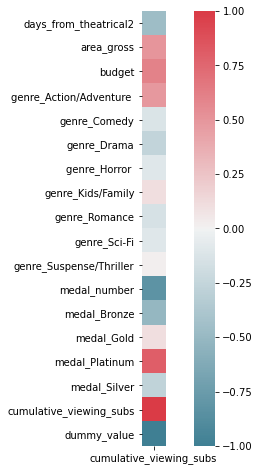

In [36]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [37]:
TARGET_COL = ['log_cumulative_first_views']

In [38]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)

<AxesSubplot:>

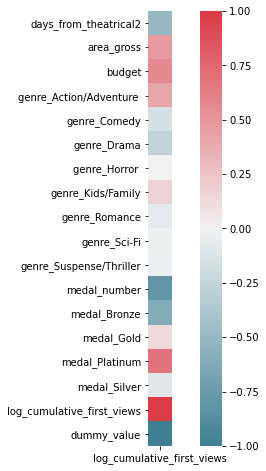

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [27]:
TARGET_COL = ['cumulative_first_views'] # cumulative_first_views

In [28]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_first_views
dummy_value,-1.00
days_from_theatrical2,-0.38
medal_number,-0.25
medal_Bronze,-0.20
genre_Drama,-0.14
genre_Comedy,-0.13
genre_Horror,-0.09
genre_Suspense/Thriller,-0.07
medal_Silver,-0.06
genre_Romance,-0.06


<AxesSubplot:>

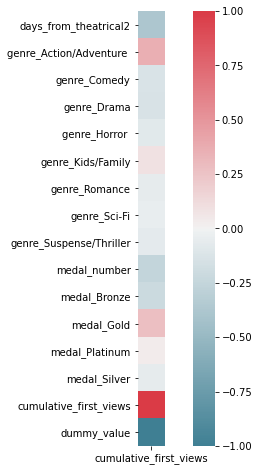

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Only movies after launch

In [51]:
data = movie_hbo[movie_hbo['days_from_max_launch'] < 0].copy()

In [52]:
data['pct_actives'] = data['pct_actives'].astype(float)

In [53]:
data.title_id.count()

72

In [54]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [55]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_viewing_subs
dummy_value,-1.00
medal_number,-0.55
days_from_theatrical2,-0.54
medal_Bronze,-0.38
genre_Drama,-0.27
genre_Comedy,-0.19
medal_Silver,-0.19
genre_Horror,-0.13
genre_Sci-Fi,-0.11
genre_Suspense/Thriller,-0.08


<AxesSubplot:>

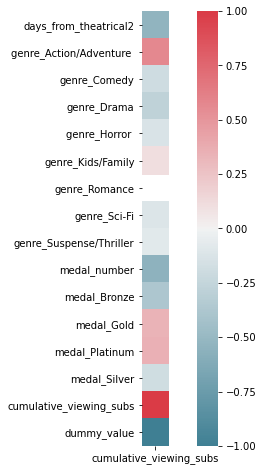

In [56]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [128]:
TARGET_COL = ['log_cumulative_first_views']

In [129]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)

<AxesSubplot:>

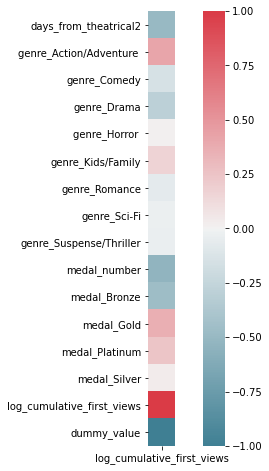

In [130]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [131]:
TARGET_COL = ['cumulative_first_views'] # cumulative_first_views

In [132]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_first_views
dummy_value,-1.00
days_from_theatrical2,-0.38
medal_number,-0.25
medal_Bronze,-0.20
genre_Drama,-0.14
genre_Comedy,-0.13
genre_Horror,-0.09
genre_Suspense/Thriller,-0.07
medal_Silver,-0.06
genre_Romance,-0.06


<AxesSubplot:>

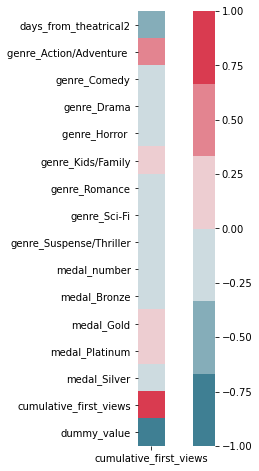

In [133]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 8, as_cmap=False),
            square=True, ax=ax)

# Other Platform

In [42]:
debut_data = pd.read_csv('Theatrical to Svod Debut.csv')

In [43]:
debut_data.head()

,Title,SVoD Debut,SVoD Debut After
0,"20.000 especies de abejas / 20,000 Species of ...",Movistar+,-
1,80 for Brady,Paramount+,-
2,100 domeniche / 100 Sundays,NOW,-
3,A Boyfriend for My Wife / Un Novio para mi Mujer,Amazon,-
4,A Complete Unknown,Hulu,-


In [44]:
debut_data.rename(columns = {'SVoD Debut After':'days_from_theatrical', 'SVoD Debut':'platform'}, inplace = True)
debut_data = debut_data[debut_data['days_from_theatrical'] != '-']
debut_data['days_from_theatrical'] = debut_data['days_from_theatrical'].replace('Day-and-Date', '0')
debut_data['days_from_theatrical'] = debut_data['days_from_theatrical'].str.replace(' days', '')
debut_data['days_from_theatrical'] = debut_data['days_from_theatrical'].astype(int)

In [45]:
debut_data_hbo = debut_data[debut_data['platform'].str.contains('HBO')]

In [46]:
debut_data_hbo.tail()

,Title,platform,days_from_theatrical
483,Tom & Jerry / Tom & Jerry: The Movie,HBO Max,0
497,Un crimen argentino / An Argentine Crime,HBO Max,50
543,West Side Story,"Disney+, HBO Max",90
545,What Went Wrong? / ¿Qué hicimos mal?,HBO Max,130
555,Wonka,HBO Max,45


In [47]:
df2 = debut_data_hbo.platform.str.split(',').apply(pd.Series)
df2.index = debut_data_hbo.set_index(['Title', 'days_from_theatrical']).index
debut_data_hbo = df2.stack().reset_index(['Title', 'days_from_theatrical'])
debut_data_hbo.rename(columns = {0:'platform'}, inplace = True)

In [48]:
df2 = debut_data_hbo.Title.str.split('/').apply(pd.Series)
df2.index = debut_data_hbo.set_index(['platform', 'days_from_theatrical']).index
debut_data_hbo = df2.stack().reset_index(['platform', 'days_from_theatrical'])
debut_data_hbo.rename(columns = {0:'title'}, inplace = True)

In [49]:
debut_data_hbo['title'] = debut_data_hbo['title'].str.strip(' ')
debut_data_hbo['title'] = debut_data_hbo['title'].replace('West Side Story', 'West Side Story (2021)')

In [50]:
platform_count = debut_data_hbo.groupby(['title']).count()['platform'].reset_index()

In [51]:
movie_hbo_platform = movie_hbo.merge(platform_count, on = ['title'], how = 'left')

In [52]:
movie_hbo_platform[['title', 'imdb_id', 'platform', 'budget']].isnull().sum()/len(launch_date)

title      0.00
imdb_id    0.00
platform   0.36
budget     0.16
dtype: float64

In [53]:
movie_hbo_platform['platform'] =movie_hbo_platform['platform'].fillna(1)

In [54]:
data = movie_hbo_platform.copy()

In [55]:
data['pct_actives'] = data['pct_actives'].astype(float)

In [56]:
FEATURE_COLS = ['days_from_theatrical2', 'area_gross', 'budget', 'genre_Action/Adventure ', 'genre_Comedy', 'genre_Drama', 'genre_Horror ', 
                'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 'medal_number', 'medal_Bronze', 
                'medal_Gold', 'medal_Platinum', 'medal_Silver', 'platform']

In [57]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [58]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_viewing_subs
dummy_value,-1.00
medal_number,-0.83
medal_Bronze,-0.51
days_from_theatrical2,-0.47
medal_Silver,-0.27
genre_Drama,-0.27
genre_Romance,-0.14
genre_Comedy,-0.12
genre_Sci-Fi,-0.10
genre_Horror,-0.09


<AxesSubplot:>

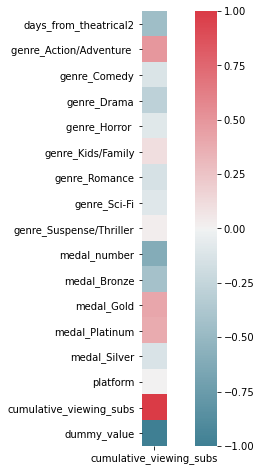

In [143]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [150]:
TARGET_COL = ['log_cumulative_first_views']

In [151]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,log_cumulative_first_views
dummy_value,-1.00
medal_number,-0.53
days_from_theatrical2,-0.50
medal_Bronze,-0.47
genre_Drama,-0.29
genre_Comedy,-0.14
genre_Romance,-0.07
platform,-0.04
genre_Suspense/Thriller,-0.03
genre_Sci-Fi,-0.03


<AxesSubplot:>

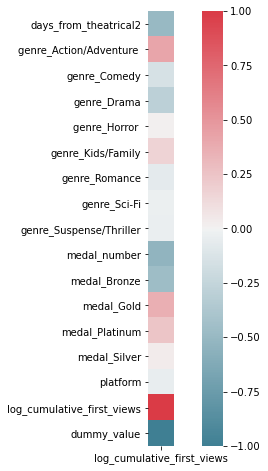

In [152]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [147]:
TARGET_COL = ['cumulative_first_views'] # cumulative_first_views

In [148]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_first_views
dummy_value,-1.00
days_from_theatrical2,-0.38
medal_number,-0.25
medal_Bronze,-0.20
genre_Drama,-0.14
genre_Comedy,-0.13
genre_Horror,-0.09
platform,-0.08
genre_Suspense/Thriller,-0.07
medal_Silver,-0.06


<AxesSubplot:>

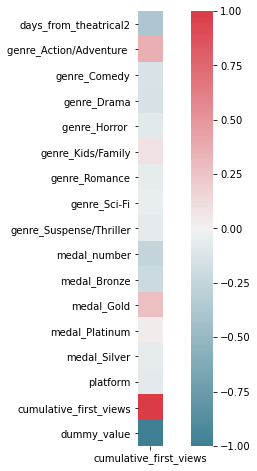

In [149]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### correlation between features

In [40]:
plot_data=data[FEATURE_COLS]
corr = plot_data.corr()
mask=np.zeros_like(corr, dtype=np.bool)

<AxesSubplot:>

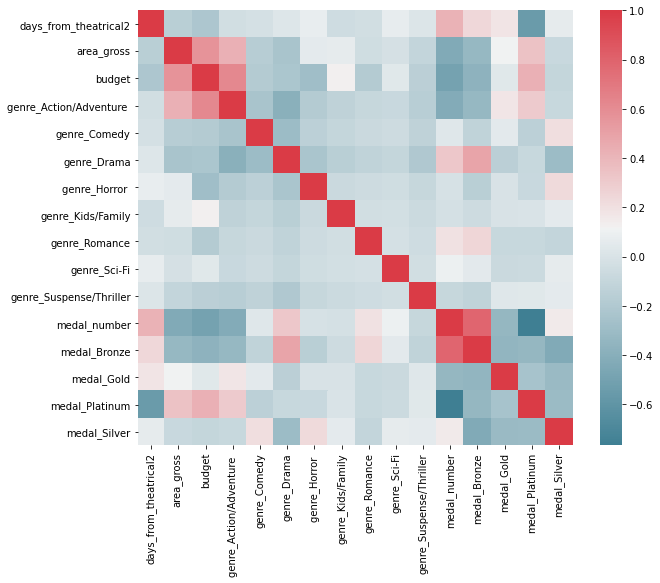

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [63]:
movie_hbo_platform.head()

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform
0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.093463,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,2,1.00
1,GXpTQtgV6ax-auwEAABc3,The Good Liar,Bronze,Drama,tt5563334,2019-11-15,2020-06-14,187,0.022345,187,186115,10519,"5,605,051.00","10,000,000.00",0,0,1,0,0,0,0,0,3,1.00
2,GYK0lqgy8KZiWvwEAAAAH,Shiva Baby,Bronze,Comedy,tt11317142,2020-03-15,2021-07-08,66,0.011300,66,307494,1415,"7,160.00",nan,0,1,0,0,0,0,0,0,3,1.00
3,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.162250,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,1,1.00
4,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.067369,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,2,1.00


In [59]:
movie_hbo_platform.to_csv('training_data.csv')